In [1]:
import yaml
import numpy as np

with open('./controller_config.yaml', 'r', encoding='utf-8') as f:
    result = yaml.load(f.read(), Loader=yaml.FullLoader)
# result['camera_matrix']
# print(result)
print(result['camera_matrix'])
print(np.matrix(result['camera_matrix']))

import cv2
import cv2.aruco as aruco
parameters = aruco.DetectorParameters_create()
aruco_dict = aruco.Dictionary_get(aruco.DICT_4X4_100)
# camera_matrix =np.matrix ([[ 522.1905267183170736, 0.0000000000000000, 308.8532705794233948  ],
#                   [ 0.0000000000000000, 522.8166355728753842, 234.2130798407917496 ],
#                   [ 0.0000000000000000, 0.0000000000000000, 1.0000000000000000 ]])
# # camera_matrix = [[1000, 0, 320], [0, 1000, 240], [0, 0, 1]]  # 示例相机矩阵
# camera_dist = np.matrix([ 0.1058497356483027 ,-0.1488874492570700 ,0.0000000000000000 ,0.0000000000000000 ,-0.8698561798572152])

camera_matrix = np.matrix(result['camera_matrix'])
camera_dist = np.matrix(result['camera_dist'], dtype=np.float32)
  # marker_length: 0.012
marker_length = 0.005
# parameters

[[1543.40965, 0.0, 969.812817], [0.0, 1541.34379, 512.276013], [0.0, 0.0, 1.0]]
[[1.54340965e+03 0.00000000e+00 9.69812817e+02]
 [0.00000000e+00 1.54134379e+03 5.12276013e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


In [ ]:
for i in range(0, 8):
    cap = cv2.VideoCapture(i)
    if cap.isOpened():
        print( 'camera open')
        while True:
            ret, img = cap.read()
            print(ret, i)
            if not ret:
                continue
            else:
                print(ret, "camera id:", i)
                print(img.shape)
            #

                cv2.imshow('5', img)
                # cv2.waitKey(10)
                c = cv2.waitKey(10)
                if c == 27:
                        break
                cap.set(cv2.CAP_PROP_FPS, 330)
                # cv2.destroyAllWindows()
    cap.release()
    cv2.destroyAllWindows()
    # break

In [ ]:
import cv2
import time
from scipy.spatial.transform import Rotation as R

import cv2.aruco as aruco

# 创建视频捕捉对象，0 表示使用默认摄像头
cap = cv2.VideoCapture(2)
cap.set(3,1920) #设置分辨率
cap.set(4,1080)

# 创建 ArUco 检测参数
parameters = aruco.DetectorParameters_create()

# 加载预定义的 ArUco 字典
# aruco_dict = aruco.Dictionary_get(aruco.DICT_6X6_250)
aruco_dict = aruco.Dictionary_get(aruco.DICT_4X4_250)
i = 0
while True:
    # 读取一帧图像
    # time.sleep(1)
    ret, frame = cap.read()
    if not ret:
        break

    # 将图像转换为灰度图
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # 检测 ArUco 标记
    corners, ids, rejectedImgPoints = aruco.detectMarkers(gray, aruco_dict, parameters=parameters)
    rvecs, tvecs, _ = aruco.estimatePoseSingleMarkers(corners,
                                                          marker_length,
                                                          camera_matrix,
                                                          camera_dist)
    
    # 估计标记的姿态
    rvecs, tvecs, _ = aruco.estimatePoseSingleMarkers(corners, marker_length, camera_matrix, camera_dist)

    # 检查返回值
    if rvecs is not None and len(rvecs) > 0:
        print("Rotation Vectors:", rvecs)
        # Rotation Vectors: [[[-3.12682862  0.03934772  0.00940102]]]
        print("Translation Vectors:", tvecs)
        # Translation Vectors: [[[0.00055413 0.00014394 0.02618797]]]
        
        # 处理第一个标记的旋转向量
        rr = R.from_rotvec(rvecs[0][0])
        print("Rotation Matrix:\n", rr.as_matrix())
         # [[ 0.99966529 -0.02520588 -0.00582934]
         # [-0.02511868 -0.9995782   0.01457627]
         # [-0.00619429 -0.01442496 -0.99987677]]
    
        # 获取欧拉角（以度为单位）
        rpy = rr.as_euler('xyz', degrees=True)

    
        # 打印欧拉角
        print("Euler Angles (before adjustment):", rpy)
        # Euler Angles (before adjustment): [-179.17346597    0.35490888   -1.4393736 ]
    
        # 确保 rpy 是一个数组并且长度为 3
        if rpy.shape == (3,):
            rpy[-1] = rpy[-1] + 360 * (rpy[-1] < 0)
            rpy[0] = rpy[0] + 360 * (rpy[0] < 0)
            print("Euler Angles (after adjustment):", rpy)
            # Euler Angles (after adjustment): [1.80826534e+02 3.54908876e-01 3.58560626e+02]
            
            # 检查 tvecs[0][0] 是否有效
            if tvecs is not None and len(tvecs) > 0:
                print("Translation Vector (in mm):", tvecs[0][0] * 1000)
                # 将平移向量转换为毫米并合并
                back = np.concatenate((tvecs[0][0] * 1000, rpy))
                print("Final Vector:", back)
                # Final Vector: [5.54131605e-01 1.43942161e-01 2.61879730e+01 1.80826534e+02
                # 3.54908876e-01 3.58560626e+02]
                
                # 绘制标记的姿态
                cv2.drawFrameAxes(frame, camera_matrix, camera_dist, rvecs[0][0], tvecs[0][0], marker_length)
            else:
                print("Translation vector is None or empty.")
        else:
            print("Unexpected shape for Euler angles:", rpy.shape)
    else:
        print("未检测到任何标记或估计姿态失败")


    # 如果检测到标记，绘制边框并显示 ID
    if ids is not None:
        frame = aruco.drawDetectedMarkers(frame, corners, ids)

    # 显示结果图像
    cv2.imshow('Aruco Detection', frame)

    # 按下 'q' 键退出
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# 释放视频捕捉对象并关闭所有窗口
cap.release()
cv2.destroyAllWindows()


In [3]:
import numpy as np

# 读取 init_pose.txt 文件
data = np.loadtxt('/home/kevin/soft_fingers/weld_planning/data/camera1/init_pose.txt')

# 计算每列的平均值
column_means = np.mean(data, axis=0)

# 打印每列的平均值
print("每列的平均值:", column_means)

每列的平均值: [ -1.06787323  -0.93581127  19.52681984 158.76748555   2.78989677
 182.55492103]


每列的平均值: [-1.46496e-02 -5.34100e-03  5.52412e-02  5.42800e-05  2.61280e-04
 -4.14000e-05]


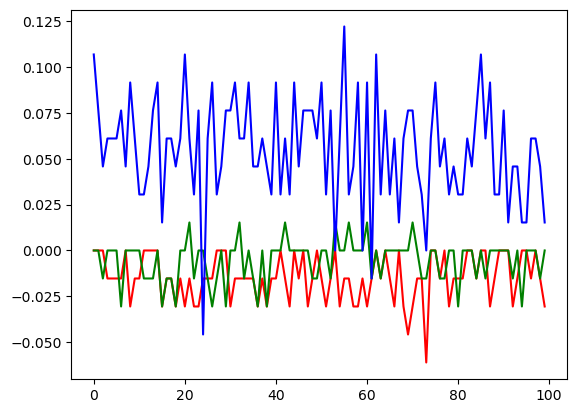

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# 读取 init_pose.txt 文件
data = np.loadtxt('/home/kevin/soft_fingers/weld_planning/data/ft/init_force.txt')

plt.plot(data[:, 0], 'r-')
plt.plot(data[:, 1], 'g-')
plt.plot(data[:, 2], 'b-')

# 计算每列的平均值
column_means = np.mean(data, axis=0)

# 打印每列的平均值
print("每列的平均值:", column_means)

每列的平均值: [ 5.90566084e+00  1.06820000e-02  1.98380000e-02 -1.83120000e-03
  3.03140000e-04  4.08940000e-04  5.15200000e-05  1.36894397e-01
 -3.94928422e-02 -3.88779411e-02  6.31374980e-01 -6.69526099e-01
  3.74186532e-01]


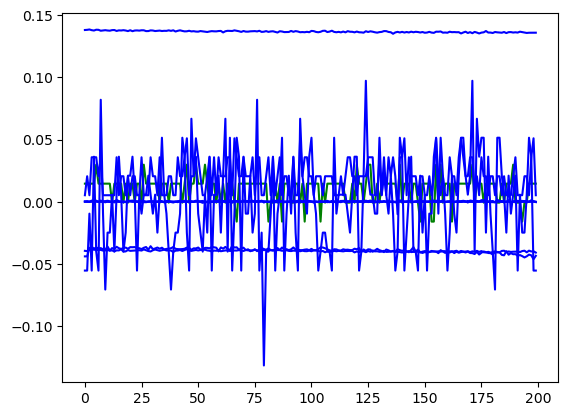

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# 读取 init_pose.txt 文件
data = np.loadtxt('/home/kevin/soft_fingers/weld_planning/data/camera1/2024-12-26-17-29.txt')

# plt.plot(data[:, 0], 'r-')
plt.plot(data[:, 1], 'g-')
plt.plot(data[:, 2], 'b-')
plt.plot(data[:, 3], 'b-')
plt.plot(data[:, 4], 'b-')
plt.plot(data[:, 5], 'b-')
plt.plot(data[:, 6], 'b-')
plt.plot(data[:, 7], 'b-')
plt.plot(data[:, 8], 'b-')
plt.plot(data[:, 9], 'b-')


# 计算每列的平均值
column_means = np.mean(data, axis=0)

# 打印每列的平均值
print("每列的平均值:", column_means)
 [-1.46496e-02 -5.34100e-03  5.52412e-02  5.42800e-05  2.61280e-04
 -4.14000e-05]